# **Importing required libraries**

In [ ]:
import numpy as np
import numpy.random as R
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, MaxPooling2D, Embedding, Concatenate
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from PIL import Image
import tensorflow as tf

# **Preparing a real dataset**

In [16]:
files = glob.glob('/kaggle/input/four-shapes/shapes/*')
files[:5]

['/kaggle/input/four-shapes/shapes/triangle',
 '/kaggle/input/four-shapes/shapes/circle',
 '/kaggle/input/four-shapes/shapes/square',
 '/kaggle/input/four-shapes/shapes/star']

In [3]:
#windows path
labels = list(set([x.split('/')[-1] for x in files]))
label_dict = {y:x for x,y in enumerate(labels)}

In [4]:
labels

['star', 'triangle', 'circle', 'square']

In [5]:
label_dict

{'star': 0, 'triangle': 1, 'circle': 2, 'square': 3}

# **Load Dataset**

In [6]:
def load_real_samples():
    x_train,y_train = [],[]
    for x,y in label_dict.items():
        files = glob.glob('/kaggle/input/four-shapes/shapes/{}/*'.format(x))
        for file in files:
            x_train.append(np.asarray(Image.open(file).resize((28,28)).convert('L')))
        y_train.extend([y for value in range(len(files))])
    x_train = np.array(x_train).astype('float32').reshape(-1,28,28,1)
    return [x_train,np.array(y_train)]

dataset = load_real_samples()

In [7]:
dataset[0].shape[0]

14970

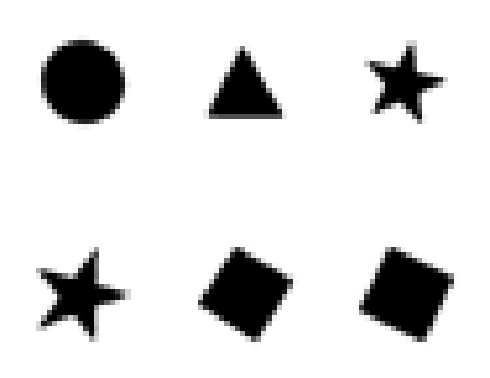

In [ ]:
def display_random_images(images, num_images=6, rows=2, cols=3):
    plt.figure(figsize=(5, 5))
    for n, i in enumerate(list(np.random.randint(0, len(images), num_images))):
        plt.subplot(rows, cols, n + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 6 random images
display_random_images(dataset[0], num_images=6, rows=2, cols=3)

# **Define Generator Network**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(28*28*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 4)))
    assert model.output_shape == (None, image_size, image_size, 4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model
generator = make_generator_model()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3136)                │         313,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3136)                │          12,544 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,928 (1.47 MB)

 Trainable params: 378,464 (1.44 MB)

 Non-trainable params: 6,464 (25.25 KB)

# **Generating a latent vector to generate fake images**

In [10]:
def generate_latent_vector(latent_dim, n_samples, n_classes=3):
    x_input = R.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = R.randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_vector(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

# **Define Discriminator Network**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size,image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model
discriminator = make_discriminator_model()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,385 (1.04 MB)

 Trainable params: 272,385 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

# **Build Condition GANs**

In [ ]:
def build_cgan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

cgan = build_cgan(generator, discriminator)
cgan.summary()

# **train CGANs**

In [ ]:
batch_size = 64
epochs = 10
batch_per_epo = int(dataset[0].shape[0] / batch_size)
half_batch = int(batch_size / 2)
for i in tqdm(range(epochs)):
    for j in range(batch_per_epo):
        #generate real sample
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        #train discriminator on real dataset
        d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
        #generate fake sample
        [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        #train discriminator on fake dataset
        d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
        #Training CGAN
        [z_input, labels_input] = generate_latent_vector(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
        g_loss = cgan.train_on_batch([z_input, labels_input], y_gan)
    print('>Loss Discriminator: {}, {} , Generator: {}'.format(d_loss1,d_loss2,g_loss))

# **Display Loss**

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# **Generate Samples**

In [ ]:
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 255.0, cmap='gray') #
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

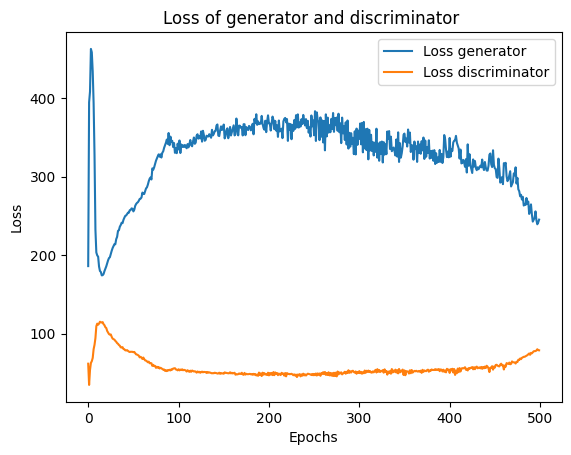

In [ ]:
plt.plot(range(len(History_gen)), History_gen, label='Loss generator')
plt.plot(range(len(History_disc)), History_disc, label='Loss discriminator')

plt.title('Loss of generator and discriminator ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import PIL
from PIL import Image
from IPython.display import display
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('/kaggle/working/image_at_epoch_{:04d}.png'.format(epoch_no))


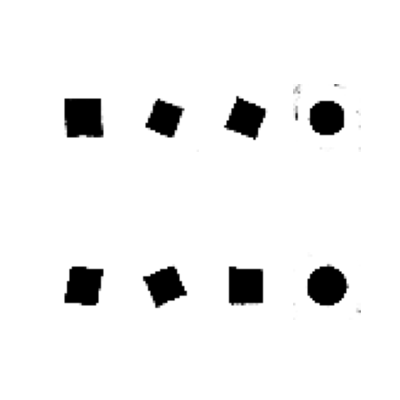

In [ ]:
display_image(EPOCHS)